# Data analysis and plots for Figure 3

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from qiskit.quantum_info import Pauli

from cut_graph import CutGraph
from compute_witness import compute_witness

In [2]:
# Load the stabilizers that make-up the plot.
with open("data/figure3_data.json", "r") as fin:
    data = json.load(fin)

In [3]:
cgs = CutGraph("134_node_graph.json")
_ = cgs.edge_stabilizers()  # will generate labels

In [4]:
zne_factors = [float(c) for c in sorted(data["locc"].keys())]
zne_stabilizers_locc = {}

for stabilizer in data["locc"]["1.0"]:
    values = [data["locc"][str(c)][stabilizer][0] for c in zne_factors]
    sigmas = [data["locc"][str(c)][stabilizer][1] for c in zne_factors]
    fit_res = np.polyfit(zne_factors, values, deg=1, cov=True, w=[1/sig for sig in sigmas])

    zne_stabilizers_locc[stabilizer] = (fit_res[0][1], np.sqrt(fit_res[1][1][1]))

For LOCC, use stabilizer values obtained from ZNE for stabilizers affected by the cut.

In [5]:
stabilizer_vals_locc, witnes_vals_locc = {"1.0": {}}, {"1.0": {}}

for stab, value in data["locc"]["1.0"].items():
    if cgs.touches_cut(Pauli(stab)):
        stabilizer_vals_locc["1.0"][stab] = zne_stabilizers_locc[stab]
    else:
        stabilizer_vals_locc["1.0"][stab] = value

Compute the witnesses.

In [6]:
witnesses = {}

for tag in ["lo", "drop"]:
    witnesses[tag] = compute_witness(data[tag]["1.0"], cgs.graph, cgs)

# Compute LOCC witnesses by taking ZNE only for those affected by the cut.
witnesses["locc"] = compute_witness(stabilizer_vals_locc["1.0"], cgs.graph, cgs)

## Plot the cumulative distribution function

Find the errors of the node stabilizers that are on a cut.

In [7]:
errors_to_flag_locc, errors_to_flag_drop, errors_to_flag_lo = [], [], []

for node in cgs.nodes_on_cut:
    stab = cgs.stabilizers([node])[0].to_label()
    errors_to_flag_locc.append(abs(stabilizer_vals_locc["1.0"][stab][0]-1))
    errors_to_flag_drop.append(abs(data["drop"]["1.0"][stab][0]-1))
    errors_to_flag_lo.append(abs(data["lo"]["1.0"][stab][0]-1))

Compute the errors of the witnesses.

In [8]:
werrors_to_flag = {"locc": [], "drop": [], "lo": []}
werrors = {"locc": [], "drop": [], "lo": []}

for tag in ["lo", "drop", "locc"]:
    for edge, val in witnesses[tag].items():
        error = abs(val[0] + 0.5)
        werrors[tag].append(error)
        
        if edge[0] in cgs.nodes_on_cut or edge[1] in cgs.nodes_on_cut:
            werrors_to_flag[tag].append(error)

Plot the cumulative distribution of the errors for stabilizers that correspond to a node of the graph.

In [9]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

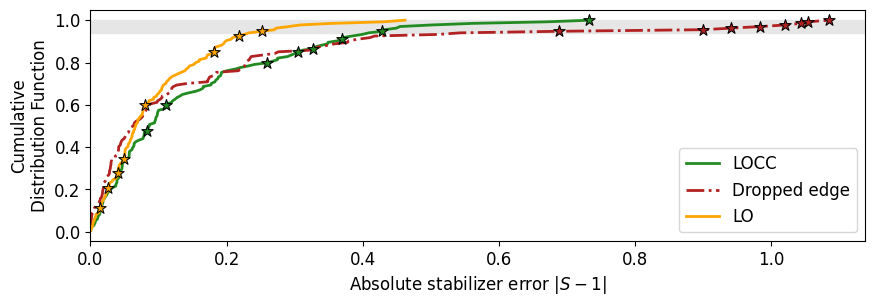

In [10]:
plt.rcParams["font.size"]= 12
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
lines = []

# Compute the stabilizer error, i.e., |S-1|. A node stabilizer has a single X in its Pauli
se_drop = [abs(x[0]-1) for p, x in data["drop"]["1.0"].items() if sum(Pauli(p).x) == 1]
se_lo   = [abs(x[0]-1) for p, x in data["lo"]["1.0"].items() if sum(Pauli(p).x) == 1]
se_locc = [abs(x[0]-1) for p, x in stabilizer_vals_locc["1.0"].items() if sum(Pauli(p).x) == 1]

cases = [
    (se_locc, "LOCC", "forestgreen", "-", errors_to_flag_locc), 
    (se_drop, "Dropped edge", "firebrick", "-.", errors_to_flag_drop), 
    (se_lo, "LO", "orange", "-", errors_to_flag_lo)
]

ax.xaxis.tick_top()
for errs, lbl, color, ls, cut_errs in cases:
    n = np.arange(1, len(errs)+1) / float(len(errs))

    # add points for the nodes that are on the cuts
    x, y = ecdf(errs)
    errs = np.sort(errs).tolist()
    ax.plot(x, y, color=color, label=lbl, lw=2, ls=ls)
    
    indices = [errs.index(err) for err in cut_errs]
    ax.scatter(cut_errs, [y[idx] for idx in indices], s=75, color=color, zorder=10, ec="k", marker="*", lw=0.75)
    lines.append((x, y, lbl, color, ls, cut_errs, [y[idx] for idx in indices]))

xlims = ax.get_xlim()
ax.fill_between(xlims, [1-len(errors_to_flag_drop)/len(se_drop)]*2, [1]*2, color=[0.9]*3)
ax.set_xlim([0, xlims[1]])
ax.set_ylabel("Cumulative\nDistribution Function")
ax.legend()
ax.xaxis.tick_bottom()
ax.set_xlabel("Absolute stabilizer error $|S-1|$");

Plot the cumulative distribution of the errors for witnesses that correspond to the edges of the graph.

Text(0.5, 0, 'Absolute witness error $|\\mathcal{W}+1/2|$')

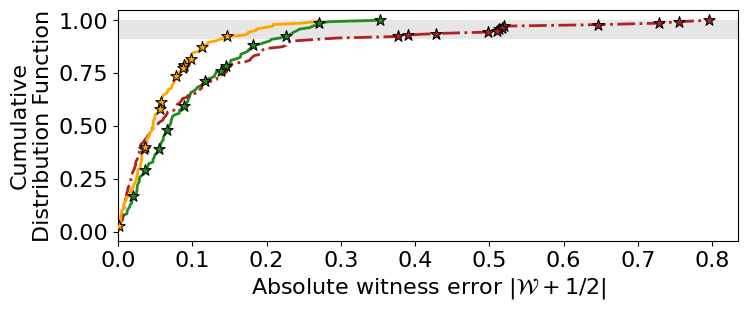

In [11]:
plt.rcParams["font.size"]= 16
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

cases = [
    (werrors["locc"], "LOCC", "forestgreen", "-", werrors_to_flag["locc"]), 
    (werrors["drop"], "Dropped edge", "firebrick", "-.", werrors_to_flag["drop"]), 
    (werrors["lo"], "LO", "orange", "-", werrors_to_flag["lo"])
]

for errs, lbl, color, ls, cut_errs in cases:
    n = np.arange(1, len(errs)+1) / float(len(errs))

    # add points for the nodes that are on the cuts
    x, y = ecdf(errs)
    errs = np.sort(errs).tolist()
    ax.plot(x, y, color=color, label=lbl, lw=2, ls=ls)
    
    indices = [errs.index(err) for err in cut_errs]
    ax.scatter(cut_errs, [y[idx] for idx in indices], s=75, color=color, zorder=10, ec="k", marker="*", lw=0.75)

xlims = ax.get_xlim()
ax.fill_between(xlims, [1-len(werrors_to_flag["drop"])/len(werrors["drop"])]*2, [1]*2, color=[0.9]*3)
ax.set_xlim([0, xlims[1]])
ax.set_ylabel("Cumulative\nDistribution Function")
ax.xaxis.tick_bottom()
ax.set_xlabel("Absolute witness error $|\mathcal{W}+1/2|$")